# EDA of our dataset

This notebook explains how our data is extracted, processed and loaded into the models that are presented in another notebook.

In [44]:
import gc
import json
import os
import random

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F_nn
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchvision.utils import make_grid
from torchvision import utils

from pycocotools import mask as coco_mask

from sklearn.metrics import precision_score, recall_score, f1_score


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading the data

In [45]:
class FootballSegmentDataset(Dataset):
    # def __init__(self, root_dir, annotation_file, train=True, transforms=None):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        # self.train = train

        with open(annotation_file, 'r') as f:
            self.coco = json.load(f)

        self.image_id_to_info = {img['id']: img for img in self.coco['images']}
        self.id_to_annotations = {}

        for ann in self.coco['annotations']:
            img_id = ann['image_id']
            if img_id not in self.id_to_annotations:
                self.id_to_annotations[img_id] = []
            self.id_to_annotations[img_id].append(ann)

        self.image_ids = list(self.id_to_annotations.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.image_id_to_info[img_id]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        height, width = img_info['height'], img_info['width']
        anns = self.id_to_annotations[img_id]
        masks = []
        for ann in anns:
            segmentation = ann['segmentation']
            rles = coco_mask.frPyObjects(segmentation, height, width)
            rle = coco_mask.merge(rles)
            m = coco_mask.decode(rle)
            masks.append(m)

        if masks:
            mask = np.any(np.stack(masks, axis=0), axis=0).astype(np.uint8)
        else:
            mask = np.zeros((height, width), dtype=np.uint8)

        mask = Image.fromarray(mask)

        if self.transforms:
            img, mask = self.transforms(img, mask)
        else:
            img = T.ToTensor()(img)
            mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

In [46]:
my_dataset = FootballSegmentDataset(
    root_dir='dataset1/images',
    annotation_file='dataset1/annotations/instances_default.json',
)

# Dataset splitting: Train - Val - Test: 70-15-15
# Train: 70%
# Val: 15% for comparison between models
# Test: 15% for final estimation of the model performance

total_size = len(my_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # To ensure the total adds up

# Split the dataset
trainset, valset, testset = random_split(my_dataset, [train_size, val_size, test_size])

# Create DataLoaders
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=8, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=0)

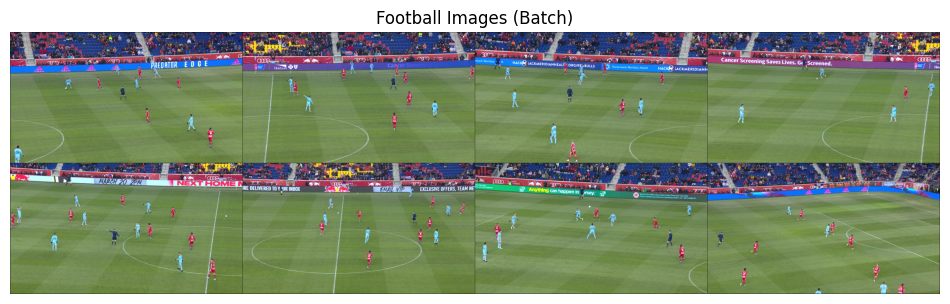

In [47]:
def show_images(imgs, title="Images"):
    # imgs: batch tensor of shape (B, C, H, W)
    img_grid = make_grid(imgs, nrow=4, normalize=True)
    img_pil = F.to_pil_image(img_grid)
    plt.figure(figsize=(12, 6))
    plt.imshow(img_pil)
    plt.title(title)
    plt.axis('off')
    plt.show()

def show_masks(masks, title="Masks"):
    # masks: batch tensor of shape (B, 1, H, W) or (B, H, W)
    # Convert to grid and use grayscale colormap
    if masks.dim() == 4:
        masks = masks.squeeze(1)  # (B, H, W)
    mask_grid = make_grid(masks.unsqueeze(1).float(), nrow=4, normalize=True)
    mask_pil = F.to_pil_image(mask_grid)
    plt.figure(figsize=(12, 6))
    plt.imshow(mask_pil, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load 1 batch
images, masks = next(iter(trainloader))

# Visualize
show_images(images, title="Football Images (Batch)")
show_masks(masks, title="Segmentation Masks (Batch)")

Missing images referenced in annotations: []
Corrupted images: []
Annotation entries with missing files: set()


Total number of images: 512
Images with more than 22 masks: [203, 215, 237, 247, 256, 266, 276, 287, 326, 327, 328, 329, 330, 331, 333, 334, 335, 336, 337, 338, 339, 340, 342, 344, 345, 346, 348, 349, 350, 351]


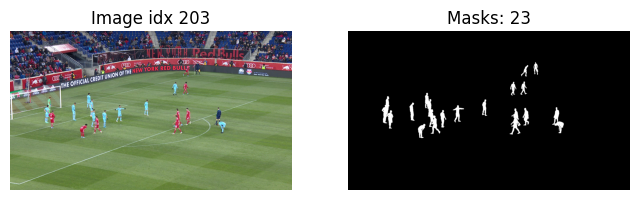

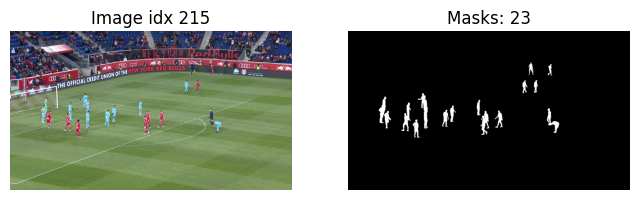

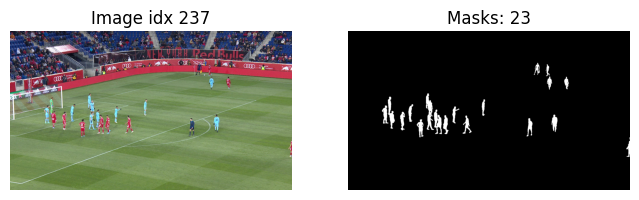

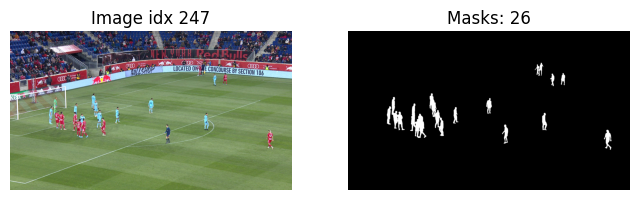

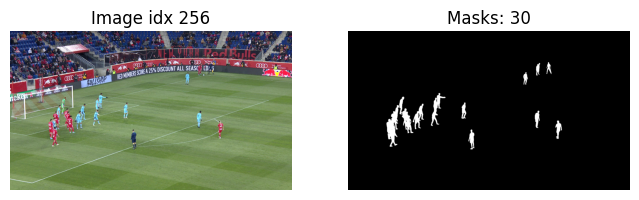

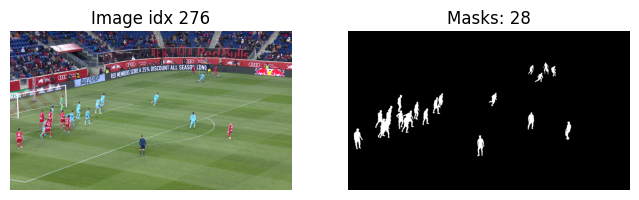

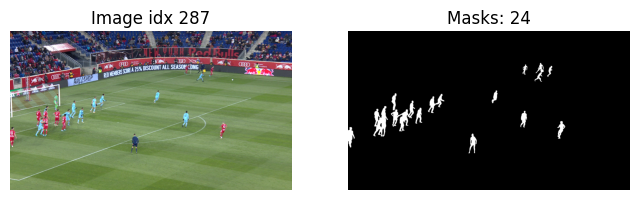

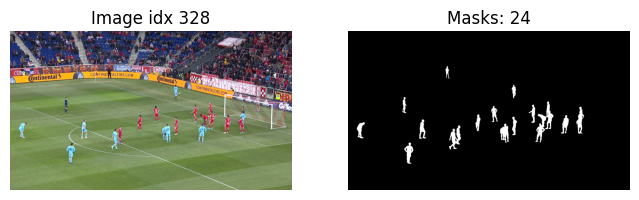

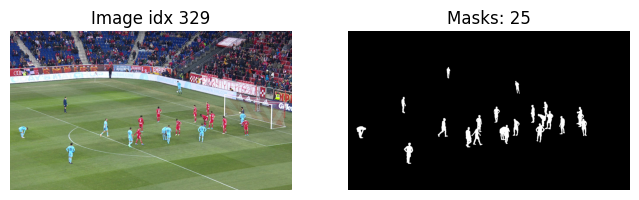

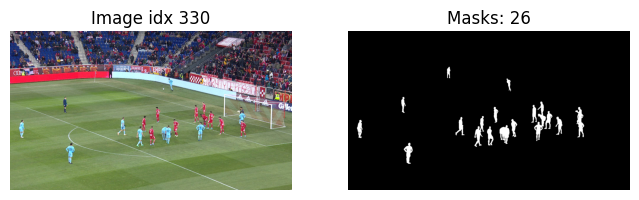

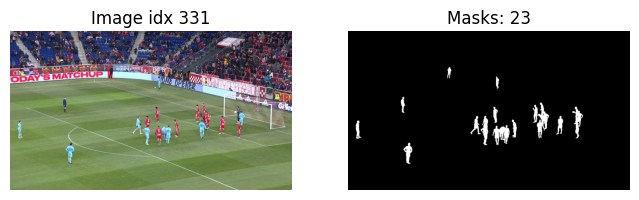

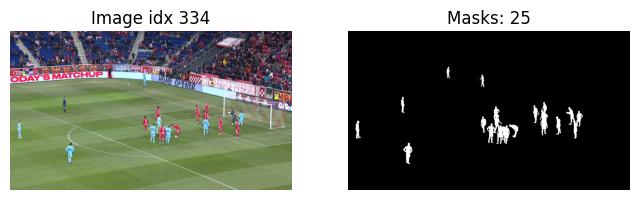

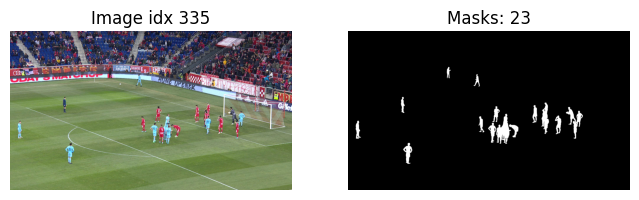

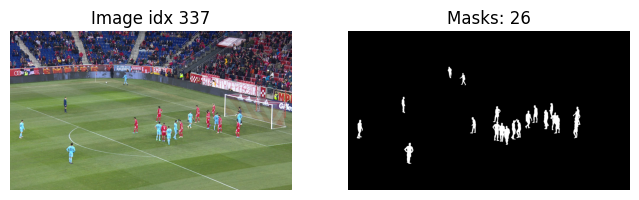

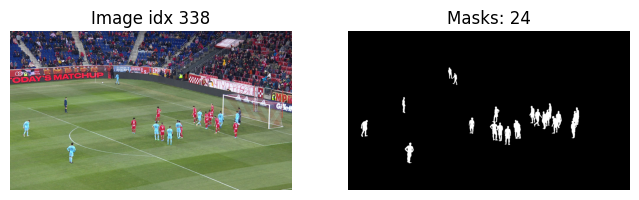

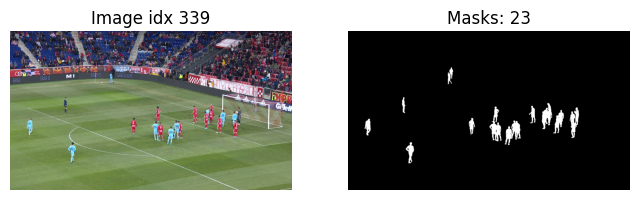

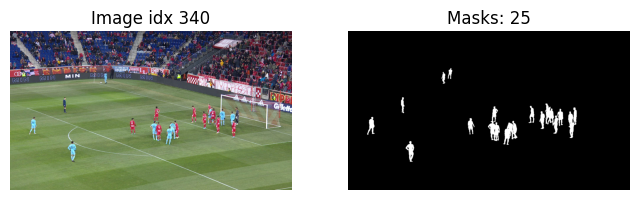

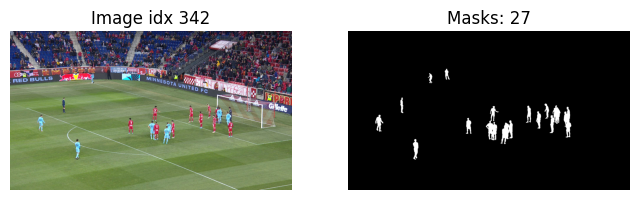

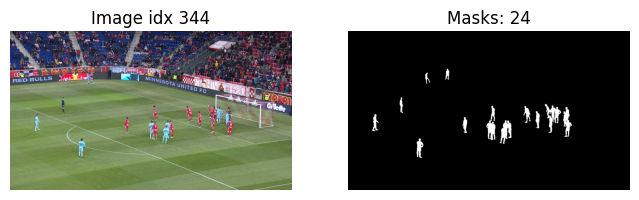

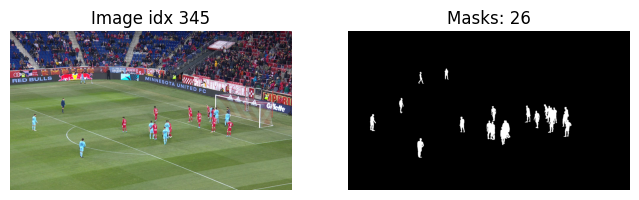

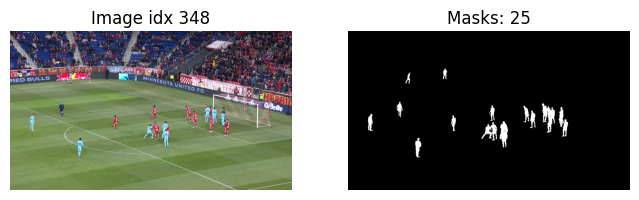

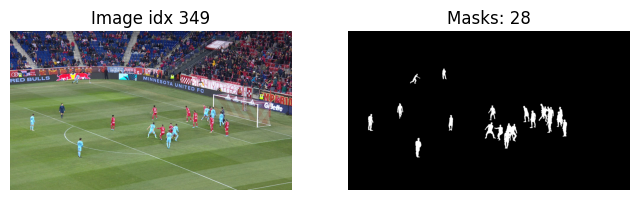

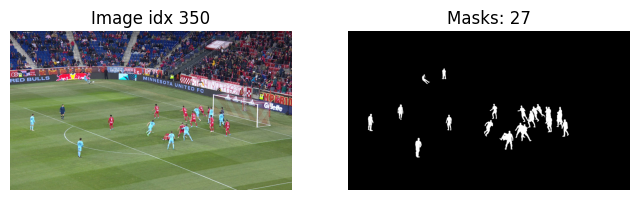

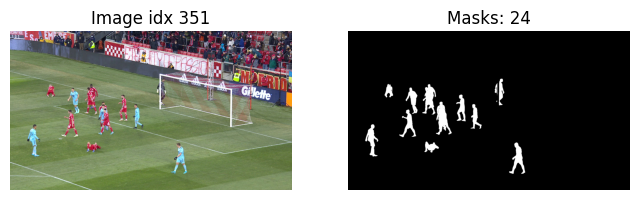

In [48]:
# Check for missing or corrupted images in the dataset and annotation file

missing_images = []
corrupted_images = []
annotation_image_ids = set(my_dataset.image_id_to_info.keys())

for img_id, img_info in my_dataset.image_id_to_info.items():
    img_path = os.path.join(my_dataset.root_dir, img_info['file_name'])
    if not os.path.exists(img_path):
        missing_images.append(img_path)
        continue
    try:
        with Image.open(img_path) as img:
            img.verify()  # Will not load the image data, but checks for corruption
    except Exception as e:
        corrupted_images.append((img_path, str(e)))

# Check for annotation entries without corresponding images
images_in_folder = set(os.listdir(my_dataset.root_dir))
images_in_annotations = set([img_info['file_name'] for img_info in my_dataset.image_id_to_info.values()])
annotation_missing_files = images_in_annotations - images_in_folder

print(f"Missing images referenced in annotations: {missing_images}")
print(f"Corrupted images: {corrupted_images}")
print(f"Annotation entries with missing files: {annotation_missing_files}")

# Calculate the number of masks per image
num_masks_per_image = [len(my_dataset.id_to_annotations[img_id]) for img_id in my_dataset.image_ids]

plt.figure(figsize=(8, 5))
plt.hist(num_masks_per_image, bins=range(0, max(num_masks_per_image)+2), edgecolor='black', align='left')
plt.xlabel('Number of Masks per Image')
plt.ylabel('Number of Images')
plt.title('Histogram of Number of Masks per Image')
plt.xticks(range(0, max(num_masks_per_image)+1))
plt.show()

print(f"Total number of images: {total_size}")

# Find images with more than 22 masks
high_mask_indices = [i for i, n in enumerate(num_masks_per_image) if n > 22]
print(f"Images with more than 22 masks: {high_mask_indices}")

for idx in high_mask_indices:
    img, mask = my_dataset[idx]
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Image idx {idx}")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask.cpu().numpy(), cmap='gray')
    plt.title(f"Masks: {num_masks_per_image[idx]}")
    plt.axis('off')
    plt.show()
    



There are no missing or corrupted images in the dataset.

We can observe that the number of masks is not equal to the number of players on the field. This is not dependent on the resolution, it is thus inherent to the dataset and the way it is annotated. Possible causes for this are the overlap of multiple players or objects covering part of the players, as can be seen for example in Image idx 351, where the goalkeeper is behind one of the goal poles.

It is also possible to notice that the referee on the field is annotated in the masks, as well as the linesmen. This could potentially lead to issues as linesmen have a similar appearence as the referee but occupy a different position on the field, often overlapping with background elements like ads, the border of the field or even other. This difference with the other people on the field may later introduce errors in the perdictions : potential false positives for identifying the linesman when it was background or false negatives for excluding them unrightfully.

We will however proceed with this dataset as it is the best one easily available to us, and it is of high quality and usability.

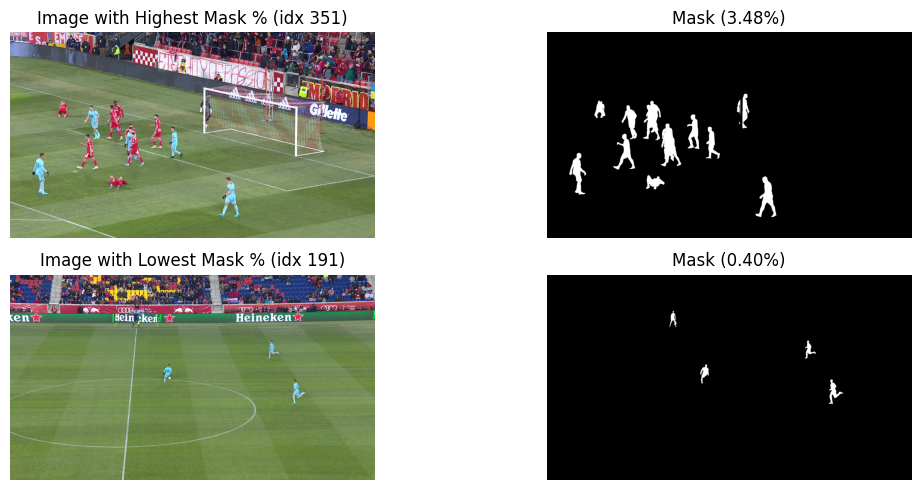

In [49]:
# Calculate the percentage of pixels marked as mask for each image
mask_percentages = []
for idx in range(len(my_dataset)):
    _, mask = my_dataset[idx]
    mask_np = mask.cpu().numpy()
    mask_percentage = 100.0 * np.sum(mask_np > 0) / mask_np.size
    mask_percentages.append(mask_percentage)

plt.figure(figsize=(8, 5))
plt.hist(mask_percentages, bins=20, edgecolor='black')
plt.xlabel('Percentage of Masked Pixels per Image (%)')
plt.ylabel('Number of Images')
plt.title('Histogram of Percentage of Masked Pixels per Image')
plt.show()

# Find indices of images with highest and lowest mask percentage
max_idx = np.argmax(mask_percentages)
min_idx = np.argmin(mask_percentages)

# Load images and masks
img_max, mask_max = my_dataset[max_idx]
img_min, mask_min = my_dataset[min_idx]

plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
plt.imshow(img_max.permute(1, 2, 0).cpu().numpy())
plt.title(f"Image with Highest Mask % (idx {max_idx})")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(mask_max.cpu().numpy(), cmap='gray')
plt.title(f"Mask (%.2f%%)" % mask_percentages[max_idx])
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(img_min.permute(1, 2, 0).cpu().numpy())
plt.title(f"Image with Lowest Mask % (idx {min_idx})")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(mask_min.cpu().numpy(), cmap='gray')
plt.title(f"Mask (%.2f%%)" % mask_percentages[min_idx])
plt.axis('off')

plt.tight_layout()
plt.show()

The percentage of regions of masks over background is relatively small, with most images having only about 2% of their pixels labeled as mask. This class imbalance is typical in segmentation tasks involving object detection on large backgrounds, such as football fields. While this could potentially make learning more challenging, modern architectures like U-Net are designed to handle this kind o imbalances effectively, especially when combined with appropriate loss functions (e.g., Dice loss or weighted cross-entropy). Therefore, the small proportion of mask pixels should not pose a significant issue for model training or performance.

In this project, multiple loss functions will be used and compared, as well as multiple model architectures inspired by U-Net and its variants.

## Images from the same dataset

As all images come from the same dataset, and from the same match and in the same order, we may encounter generalisation issues because of high correlation or causality in this data.
Our strategy to robustify the model is to apply random transformations, via the JointTransform class.

This will have a 0.5 chance of horisontal flipping, 0.5 chance of vertical flipping and will induce random color jittering.

In [51]:
class JointTransform:
    def __init__(self, resize=(1080, 1080), hflip_prob=0.5, vflip_prob=0.5):
        self.resize = resize
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.color_jitter = T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    def __call__(self, img, mask):
        # Resize
        img = F.resize(img, self.resize)
        mask = F.resize(mask, self.resize, interpolation=Image.NEAREST)

        # Random horizontal flip
        if random.random() < self.hflip_prob:
            img = F.hflip(img)
            mask = F.hflip(mask)

        # Random vertical flip
        if random.random() < self.vflip_prob:
            img = F.vflip(img)
            mask = F.vflip(mask)

        # Color jitter (only on image)
        img = self.color_jitter(img)

        # To tensor
        img = F.to_tensor(img)
        mask = torch.from_numpy(np.array(mask)).long()

        # Normalize image only
        img = self.normalize(img)

        return img, mask

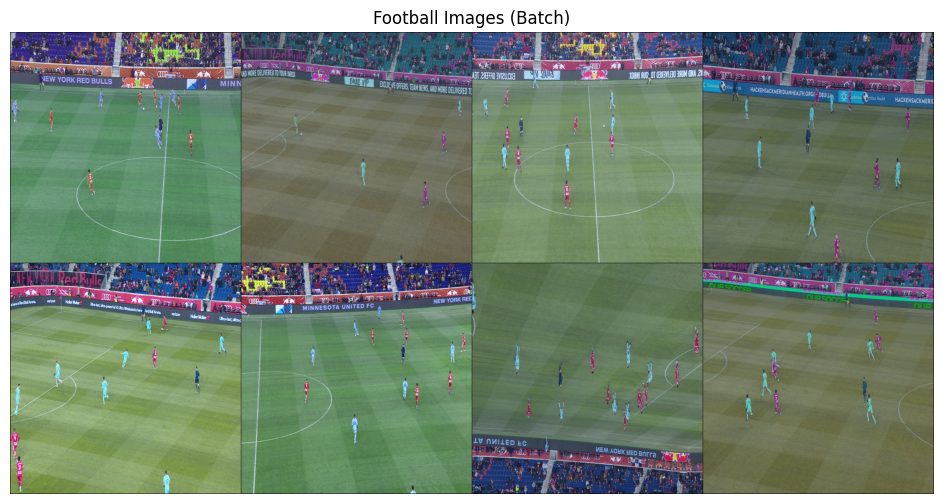

In [53]:
image_transform=T.Compose([
    T.Resize((1080, 1080)),
    T.ToTensor()
])

my_transform = JointTransform(resize=(1080, 1080), hflip_prob=0.5, vflip_prob=0.5)

my_dataset = FootballSegmentDataset(
    root_dir='dataset1/images',
    annotation_file='dataset1/annotations/instances_default.json',
    transforms=my_transform
)


# Dataset splitting: Train - Val - Test: 70-15-15
# Train: 70%
# Val: 15% for comparison between models
# Test: 15% for final estimation of the model performance

total_size = len(my_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # To ensure the total adds up

# Split the dataset
trainset, valset, testset = random_split(my_dataset, [train_size, val_size, test_size])

# Create DataLoaders
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=8, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=0)

# Load 1 batch
images, masks = next(iter(trainloader))

# Visualize
show_images(images, title="Football Images (Batch)")
show_masks(masks, title="Segmentation Masks (Batch)")